## Getting Started with Coevolutionary sequence analysis

This notebook demonstrates how to compute co-evolution between two protein sequences with a small test set of alignments. We explore two different co-evolution based models: 1) Mirror Tree and 2) The Statistical Coupling Analysis (SCA). Mirror Tree calculates a co-evolution score based on correlations in the number of amino acid substitutions across protein sequences, with a partial regression against a phylogenetic model.  SCA calculates a co-evolution based score based on correlations in amino acid frequency between specific amino acid positions, and does not include an explicit phylogenetic correction.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import coevo2 as ce
import itertools as it
import numpy as np
import copy
import time

In [2]:
# If you need to edit the library code you can update the imported version using 'reload'
reload(ce)

<module 'coevo2' from 'coevo2.pyc'>

In [3]:
#make a nice blue-white-red colormap
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0,  0.230, 0.230),
                   (0.5,  0.865, 0.865),
                   (1.0,  0.706, 0.706)),

        'green': ((0.0,  0.299, 0.299),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.016, 0.016)),

        'blue':  ((0.0,  0.754, 0.754),
                  (0.5,  0.865, 0.865),
                  (1.0,  0.150, 0.150))}
sci_bluered = LinearSegmentedColormap('BlueRed1', cdict)

### 1. Load a test set of seven protein multiple sequence alignments.

Here we will consider seven alignments: 1)nrdA1, 2)nrdA2, 3)nrdB, 4)folA, 5)thyA, 6) cydA, 7) cydB. In this set, nrdA/nrdB and cydA/cydB are known to form a physical complex, and folA/thyA functionally interact but do not bind. Alignments 1 and 2 (nrdA1 and nrdA2) are actually two halves of the nrdA sequence alignment, and serve as a positive control for interaction prediction. 

The alignments are loaded and stored as Prot objects, which organizes the alignment and species annotation information of a given protein. Note that upon creation of prots object using the function prots_from_scratch, alignments are automatically filtered to remove positions with more than 20% gaps, and sequences with more than 30% gaps. Prots are grouped under the ProtSet class, which is used to efficiently apply pairwise coevolutionary analysis. Another useful object is the ProtPair class. ProtPairs are generated upon initialization of ProtSet, and refer to all possible pairs of Prots (without duplicating any of their data).

In [4]:
names = ['h1nrdA','h2nrdA','nrdB','folA','thyA', 'cydA', 'cydB']
algPath = 'TestSet/eggNOG_aligns/'
prots = ce.prots_from_scratch(names,path2alg=algPath)
ps = ce.ProtSet(prots,names)

### 2. Evaluate Alignment quality

Print out some stats on alignment size, and plot the fraction of gaps per sequence, and the fraction of gaps per position.

In [5]:
#this is plotting code - for making the box and whiskers plots below.
def fancy_box(data,names,outliers=False, fsize=(12,4)):
    plt.figure(figsize=fsize)
    ax = plt.gca()
    bp = ax.boxplot(data, patch_artist=True, showfliers=outliers)
    lw = 2.5
    for box in bp['boxes']:
        box.set(color='#7570b3', linewidth=lw)
        box.set(facecolor='#1b9e77' )
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=lw)
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=lw)
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=lw)
    plt.xticks(np.arange(1,len(names)+1),names,size=16);
    plt.yticks(size=14);

The code below just loops over the Prot objects and counts the number of 0's in their msa_num. Note that the msa attribute of Prot is a pandas DataFrame and not just a numpy array. This is necessary for indexing rows based on species identifier. 

In [6]:
gap_pos_frac,gap_seq_frac = [],[]
for pt in ps.prots: # This just loops over prots and counts the number of 0's in their msa_num
    gap_bool = pt.msa.values==0
    print('Alignment: %s has %i seqs and %i positions' % (pt.name,pt.msa.shape[0],pt.msa.shape[1]))
    gap_seq_frac.append(gap_bool.mean(axis=1))
    gap_pos_frac.append(gap_bool.mean(axis=0))

Alignment: h1nrdA has 1690 seqs and 238 positions
Alignment: h2nrdA has 1692 seqs and 266 positions
Alignment: nrdB has 1002 seqs and 290 positions
Alignment: folA has 1182 seqs and 142 positions
Alignment: thyA has 1110 seqs and 253 positions
Alignment: cydA has 1320 seqs and 394 positions
Alignment: cydB has 1130 seqs and 301 positions


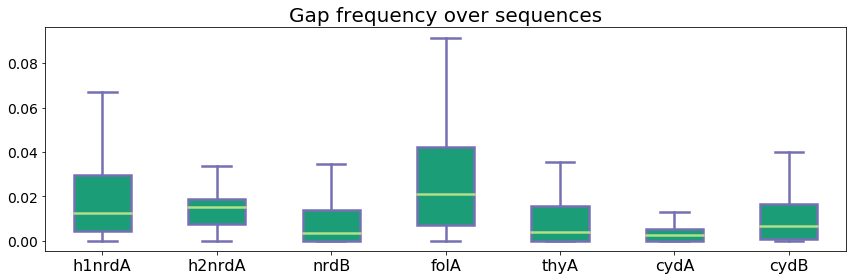

In [7]:
fancy_box(gap_seq_frac,names,outliers=False) # I need a better looking outlier marker
plt.title('Gap frequency over sequences',fontsize=20);
plt.tight_layout()

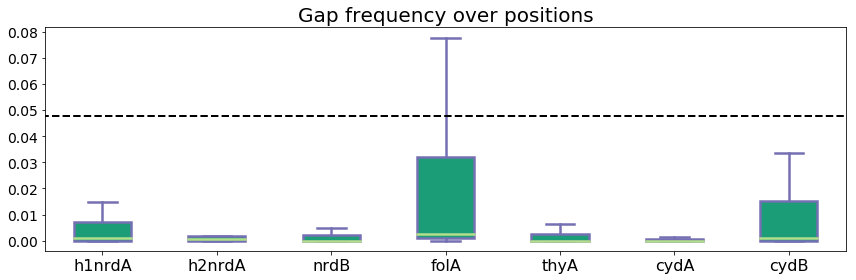

In [8]:
# 1/21 is just under 0.05
fancy_box(gap_pos_frac,names)
plt.title('Gap frequency over positions',fontsize=20)
plt.plot([0,11.5],(1./21)*np.ones(2),'k--',linewidth=2);
plt.tight_layout()

### 3. Create the Phylogenetic model for Mirror Tree

The PhyloSet class is similar to ProtSet but it contains methods specific to constructing phylogenetic vectors. I am going to build two different phylogenetic models below. The first phylogenetic model "phylo1"  is generated from the list of Prots in my ProtSet (the all protein average). The second phylogenetic model "phylo2" is loaded up from an indpendent set of protein families which correspond directly to 10 housekeeping genes often used to compute genomic distance (Junier and Rivoire, PloS ONE, 2016). Creating a PhyloSet object has three steps. The first is initializing it with a list of Prots. The second is to call the "set_indexer" method, which determines the set of species to be included in our model of phylogeny. This method has one key argument, called "thresh." Thresh indicates the minimum number of proteins in our PhyloSet that need to be present in a given species. Using a thresh of 5 means that only species containing at least 5 of the proteins in my analysis will be included in our model of phylogeny (and all subsequent steps of this analysis). The final step in setting up our phylogenetic model is to calculate its sequence similarity matrix, which is done using the method set_sim_mat. 

In [9]:
phylo_names = ['aspS','ffh','lepA','pgk','recN','rho','rpoA','ruvB','tig','uvrB']
phylo_prots = ce.prots_from_scratch(phylo_names,path2alg='TestSet/eggNOG_aligns/phylogenes/')

In [10]:
phylo1 = ce.PhyloSet(ps.prots)
phylo1.set_indexer(thresh=4)
phylo1.set_sim_mat()
phylo2 = ce.PhyloSet(phylo_prots)
phylo2.set_indexer(thresh=7)
for pt in phylo2.prots:  # temporary fix for duplicated locus ids in the same msa
    pt.msa = pt.msa[~pt.msa.index.duplicated(keep='first')]
phylo2.set_sim_mat()

Keeping: 1210 species
Keeping: 1641 species


### 4. Compute Effective Species across proteins and protein pairs
We apply species weights, in which highly similar species (within some delta, e.g. more than 0.9 identical) are downweighted to account for over-representation in the alignment. In the next block of code, we sum across species weights to obtain the effective species in each protein or protein pair. The PhyloSet object contains an attribute called "index" which is a list of taxids for which we've modeled phylogeny. You can feed this into the filter_aln or filter_alns methods of Prots and ProtPairs respectively. What that does is filter the species set of the given protein family or pair of families down to the species set defined by our list of taxids. In the case of ProteinPairs, this operation also matches paralogues based on genomic distance (proxied by geneID, as we discussed in the past). The filter_aln method returns a filtered multiple sequence alignment in numerical form as well as the corresponding list of taxids (which is the same length as the rows of the msa). As a result, the taxids returned by this method can contain duplicate entries for a given species which corresponds to the number of paralogues. I use this function to obtain the relevant taxids for each protein and protein pair in the analysis. Then I feed the list of taxids corresponding to the alignment(s) back into my phylogeny object using the method PhyloSet.info. This returns a bunch of things used to compute mirror-tree: normalized phylogenetic vecotrs (phylo_vec), species weights (specw), species pair weights (pwsw), and effective number of species PAIRS (Meff). Here I simply sum over specw to obtain the number of effective species.

Below, we do this for phylo model 1 (the all protein average), and use a delta (minimum distance in sequence identity) of 0.1:

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


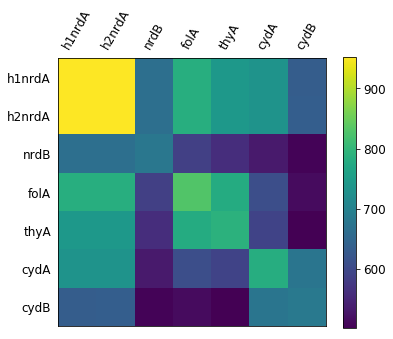

In [11]:
Nprot = len(ps.prots)
meffmat = np.zeros((Nprot,Nprot))
for pair in ps.pairs: 
    msa1, msa2, tids = pair.filter_alns(phylo1.index) # return one msa for each family and a list of taxids
    phylo_vec,specw,pwsw,Meff = phylo1.info(tids,0.1)
    meffmat[pair.ij] = specw.sum()
meffmat = ce.symmetrize(meffmat)
for j,pt in enumerate(ps.prots): 
    msa, tids = pt.filter_aln(phylo1.index)
    phylo_vec, specw, pwsw, Meff = phylo1.info(tids, 0.1)
    meffmat[j,j] = specw.sum()
    
plt.figure(figsize=(6,5))
plt.imshow(meffmat,cmap='viridis');
  
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'on'}
plt.tick_params(axis='both', **opts)
plt.xticks(range(0,Nprot), ps.names, size=12, rotation=60);
plt.yticks(ticks, ps.names, size=12);
cbar = plt.colorbar();
cbar.ax.tick_params(labelsize=12) 

Here, we have at least 500 effective species for each gene pair! Our goal is 100 or more, so this seems pretty good. Increasing delta lowers the number of effective species, as expected.

### 5. Perform mirrortree for each of the two phylogenetic models

The mirror-tree function  is very simple. Just input a ProtSet and a phylogenetic model and it will return the pair-wise full-length mirror-tree matrix. The third argument specifies the delta for sequence weightings, and in the code, defaults to 0.1.

In [12]:
mt_mat1 = ce.mirror_tree(ps,phylo1,0.1)
mt_mat2 = ce.mirror_tree(ps,phylo2, 0.1)

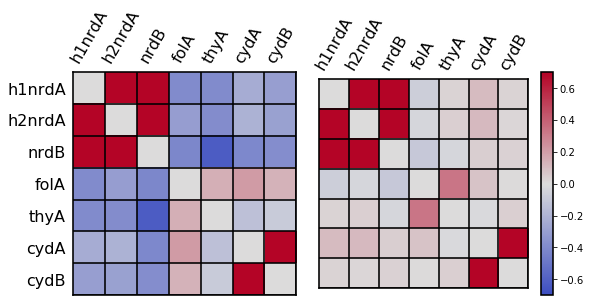

In [13]:
#plotting the results
DIVIDERWIDTH = 1.6
plt.figure(figsize=(12,4))
plt.rcParams['axes.linewidth'] = DIVIDERWIDTH # Change axes thickness

#Stuff for generative divider lines
Nprot = len(ps.prots)
span = np.array([0,Nprot]) - 0.5
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
divs = ticks+0.5
ones = np.ones(2)

# A loop, the first chunk of which decides when/where to add tick labels
for j,mat in enumerate([mt_mat1,mt_mat2]):
    plt.subplot(1,3,j+1)
    plt.imshow(mat,cmap=sci_bluered,vmin=-0.7,vmax=0.7);
    opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'on'}
    plt.tick_params(axis='both', **opts)
    plt.xticks(range(0,len(ps.names)), ps.names, size=16, rotation=60);
    if j==0: plt.yticks(ticks, ps.names, size=16);
    else: plt.tick_params(axis='y',left='off',labelleft='off')
    
    # This code is adapted from my thesis and adds black divider lines
    for pos in divs:
        plt.plot(span, pos*ones, color='k', linewidth=DIVIDERWIDTH)
        plt.plot(pos*ones, span, color='k', linewidth=DIVIDERWIDTH)  
plt.colorbar()
# The pad arguments can be used to make your subplots closer together
plt.tight_layout(pad=0.3, w_pad=-1)

The matrix on the left is with phylogenetic model 1 (average over all prots in this test set), and the right with model 2 (housekeeping genes). These results indicate that: 1) the two halves of nrdA strongly co-evolve (as expected), 2) that nrdB coevolves with nrdA with a magnitude similar to intra-protein co-evolution, 3) that cydA/cydB coevolves with a magnitude similar to intra-protein co-evolution, and 4) there is mild (phylogenetic model dependent) co-evolution between folA and thyA. Further analysis of more protein pairs is necessary to establish signficance cutoffs for defining interactions, and to assess model performance.

### 6. Compute SCA matrices (positional co-evolution) for each of the protein pairs.

Now, we want to compare the outcome of mirrortree to a positional co-evolution approach without an explicit phylogenetic correction: SCA. Note that we still pass in the phylogenetic model as an argument to ensure that the sequence filtering and sequence weights are identical as for mirrortree, even though we don't otherwise use the phylo model in the calculations.

We compute the full sca matrix for all individual proteins and protein pairs. As a first try for establishing an interaction score, we compute the two values (sca_score and sca_score2, see also the ce.sca() function for details). In both cases, we take the average co-evolution over all inter-protein position pairs. In the second case, we "correct" the score for random co-evolution by computing and subtracting a SCA matrix in which the two gene alignment has been shuffled by species (randomly concatenating genes). So, in the first case, $P$ between two proteins $x$ and $y$ is: $P_{xy} = \sum_{ij}\tilde{C_{ij}} /N$, where $i$ and $j$ iterate over all positions in proteins $x$ and $y$, and $N$ is the total number of pairs considered in the sum. The corrected sca_score2 is: $\hat{P}_{xy} = \sum_{ij}{\tilde{C}_{ij} - \tilde{C}_{ij}^{rand}} /N$

For larger test sets it would be good to consider parallelizing this part, e.g. with pool (see pos_mirror_tree function in coevo2.py for an example). For this small test set, the next block of code takes a few minutes to run on my laptop.

In [14]:
start_time = time.time()
protsmats,pairmats,sca_score,sca_score2 = ce.sca(ps,phylo1)
print("--- %.2f minutes ---" % ((time.time() - start_time)/60))

for pt,sca in it.izip(ps.prots,protsmats): pt.sca_mat = sca
for pair,sca_cat in it.izip(ps.pairs,pairmats): pair.sca_mat = sca_cat
np.save('GettingStartedSCACalcs.npy',ps)

--- 3.87 minutes ---


This next block is not strictly necessary for the hackathon, but is good for error checking and understanding the SCA code. 

Here we compare the SCA calculations from above (as implemented in the ce toolbox) with the original SCA implementation in scaTools (as distributed on github). We take protein 3 (DHFR, folA) and the correlations between folA and thyA as our test set.

We observe that the calculations agree, though there is a small amount of noise that should be better understood at some point. (which possibly emerges from pseudocounting differences?)

sca filtering gives: 1035 seqs and 142 pos for DHFR
comparing to: 1035 seqs and 142 pos
sca filtering gives: 958 seqs and 395 pos for the pair
comparing to: 958 seqs and 395 pos


<function matplotlib.pyplot.tight_layout>

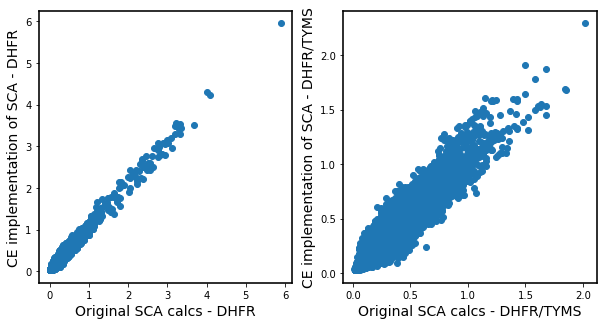

In [19]:
# initialize the test set
import scaTools as sca
msa_test,tids = ps.prots[3].filter_aln(phylo1.index)
pairmsa_test1,pairmsa_test2,tids2 = ps.pairs[15].filter_alns(phylo1.index)
pairmsa_test = np.concatenate([pairmsa_test1,pairmsa_test2],axis=1)

################
#read in and pre-process the alignment
hd,seqs = sca.readAlg('TestSet/eggNOG_aligns/folA_trimmed_ENOG4108YYV.fasta')
hd2,seqs2 = sca.readAlg('TestSet/eggNOG_aligns/thyA_trimmed_ENOG4105C0V.fasta')

#the ce code filters highly gapped positions first, here we do the same
seqw0 = sca.seqWeights(seqs)
seqw02 = sca.seqWeights(seqs2)
alg,iposkeep = sca.filterPos(seqs,seqw0,0.2)
alg2,iposkeep2 = sca.filterPos(seqs2,seqw02,0.2)

#filter the alignment to contain only the same taxids from phylo1
allhdtids = [h.split('.')[0] for h in hd]
allhdtids2 = [h.split('.')[0] for h in hd2]
ixToKeep = [allhdtids.index(tid) for tid in tids]
ixToKeepPair1 = [allhdtids.index(tid) for tid in tids2]
ixToKeepPair2 = [allhdtids2.index(tid) for tid in tids2]

hdtest = [hd[k] for k in ixToKeep]
algtest = [alg[k] for k in ixToKeep]
hdpair1 = [hd[k] for k in ixToKeepPair1]
algpair1 = [alg[k] for k in ixToKeepPair1]
hdpair2 = [hd2[k] for k in ixToKeepPair2]
algpair2 = [alg2[k] for k in ixToKeepPair2]ß
algpair = [algpair1[k]+algpair2[k] for k in range(len(algpair1))]

msa_num = sca.lett2num(algtest)
cat = sca.lett2num(algpair)

print ('sca filtering gives: %i seqs and %i pos for DHFR' % (len(algtest),len(algtest[0])))
print ('comparing to: %i seqs and %i pos' % (msa_test.shape[0],msa_test.shape[1]))
print ('sca filtering gives: %i seqs and %i pos for the pair' % (len(cat),len(cat[0])))
print ('comparing to: %i seqs and %i pos' % (pairmsa_test.shape[0],pairmsa_test.shape[1]))

###############
#compute SCA
seqw = sca.seqWeights(algtest)
Csca, tX, Proj = sca.scaMat(msa_num, seqw, 'Frob', 0.03)
seqw = sca.seqWeights(algpair)
Csca_cat, tX, Proj = sca.scaMat(cat, seqw, 'Frob', 0.03)

###############
#make plots
plt.rcParams['figure.figsize'] = 10,5
plt.subplot(121)
plt.plot(Csca.flatten(),ps.prots[3].sca_mat.flatten(),'o')
plt.xlabel('Original SCA calcs - DHFR', fontsize=14)
plt.ylabel('CE implementation of SCA - DHFR', fontsize=14)

plt.subplot(122)
plt.plot(Csca_cat[0:len(algpair1[0]),len(algpair1[0]):].flatten(),\
         ps.pairs[15].sca_mat.flatten(), 'o')
plt.xlabel('Original SCA calcs - DHFR/TYMS', fontsize=14)
plt.ylabel('CE implementation of SCA - DHFR/TYMS', fontsize=14)
plt.tight_layout()
#there is a small amount of variation... could be coming from subtle diffs in pseudocounting?
#but overall looks good.

As the last step, we examine the SCA score matrices for comparison to the mirrortree predictions.

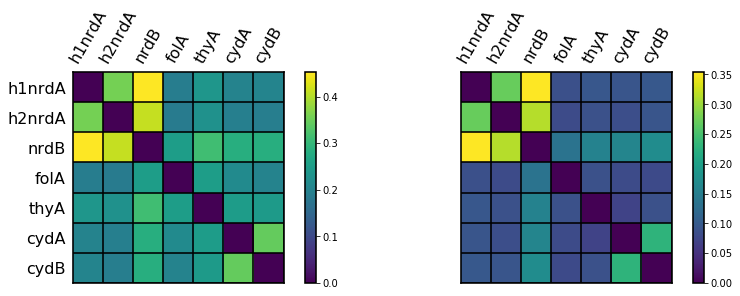

In [17]:
#plotting the results
DIVIDERWIDTH = 1.6
plt.figure(figsize=(12,4))
plt.rcParams['axes.linewidth'] = DIVIDERWIDTH # Change axes thickness

#Stuff for generative divider lines
Nprot = len(ps.prots)
span = np.array([0,Nprot]) - 0.5
ticks = np.convolve(np.insert(range(1,Nprot+1), 0, 0), np.ones((2,))/2, mode='valid') - 0.5 
divs = ticks+0.5
ones = np.ones(2)

np.fill_diagonal(sca_score,0)

#plot the sca score matrices
# A loop, the first chunk of which decides when/where to add tick labels
for j,mat in enumerate([sca_score,sca_score2]):
    plt.subplot(1,2,j+1)
    plt.imshow(mat,cmap='viridis');
    opts = {'left':'off','bottom':'off', 'top':'off', 'labelbottom':'off','labeltop':'on'}
    plt.tick_params(axis='both', **opts)
    plt.xticks(range(0,9), ps.names, size=16, rotation=60);
    if j==0: plt.yticks(ticks, ps.names, size=16);
    else: plt.tick_params(axis='y',left='off',labelleft='off')
    plt.colorbar()
    # This code is adapted from my thesis and adds black divider lines
    for pos in divs:
        plt.plot(span, pos*ones, color='k', linewidth=DIVIDERWIDTH)
        plt.plot(pos*ones, span, color='k', linewidth=DIVIDERWIDTH)  

# The pad arguments can be used to make your subplots closer together
plt.tight_layout(pad=0.3, w_pad=-1)

On the left, we plot sca_score, and on the right sca_score2 (which is corrected by a randomized matrix). In contrast to mirrortree, which shows some weak co-evolution between folA/thyA (though in a phylogenetic model dependent manner), SCA primarily detects physical complexes. While more data is needed to establish generality, this observation seems consistent with the view that co-evolution at interfaces might be local (and positional) while co-evolution between epistatic (but non-binding) proteins might be more distributed across positions. Thus, sequence-wide approaches like mirror tree may be more appropriate for capturing functional, rather than physical interactions.